## Probabilities and Models

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from core import events, probability_matrix, direct_query, code_toggle
import scipy
from sklearn.utils.extmath import cartesian
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from IPython.display import HTML

In [ ]:
epl = events(league=8)

In [2]:
laliga = events(league=564)

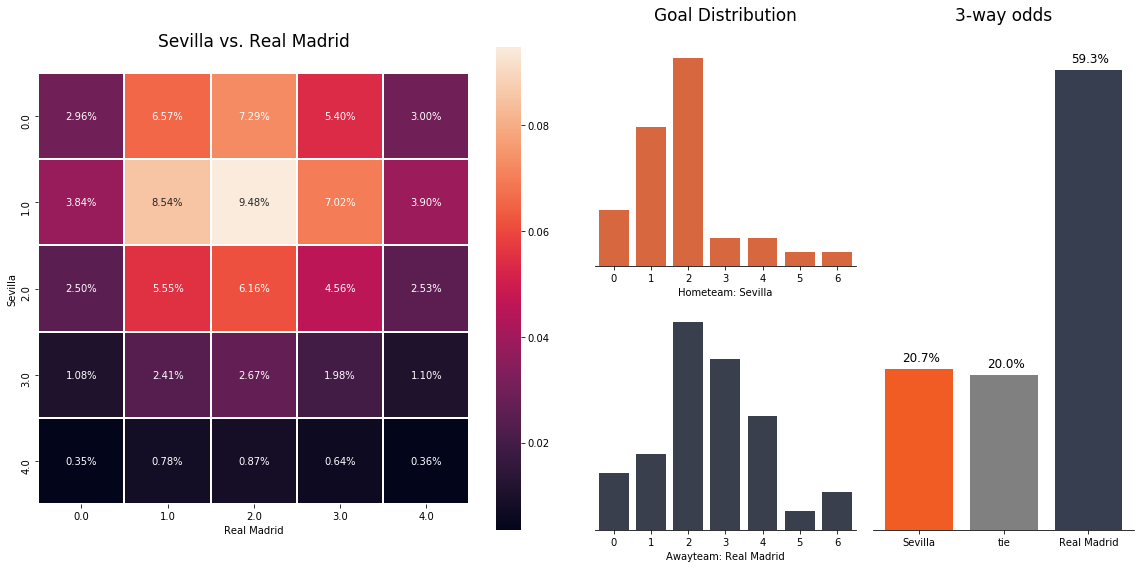

In [3]:
probability_matrix(laliga, hometeam = 'Sevilla', awayteam='Real Madrid', goals_list=[0,1,2,3,4], season=['2017/2018','2016/2017'], save_image=True);

## Step by step calculations

In [ ]:
s2015 = epl[epl['season'] == '2015/2016']

#game result only (removing duplicates for all events. Another option is to query fixtures only w/o events)
gs2015 = s2015[['fixture_id','localname', 'localteam_score','visitorteam_score','visitorname','season']].drop_duplicates()

In [ ]:
hometeam = 'Tottenham Hotspur'
awayteam = 'Everton'

### Attack Strenght

In [ ]:
average_home = np.sum(gs2015['localteam_score'])/len(gs2015)
average_away = np.sum(gs2015['visitorteam_score'])/len(gs2015)

print ('Premier League 2015/2016')
print ('Home: ', average_home, '\t\tAway :', average_away)

In [ ]:
tot_att_home = np.sum(gs2015[gs2015['localname']==hometeam]['localteam_score'])/len(gs2015[gs2015['localname']==hometeam])/average_home
tot_att_away = np.sum(gs2015[gs2015['visitorname']==hometeam]['visitorteam_score'])/len(gs2015[gs2015['visitorname']==hometeam])/average_away

print (hometeam)
print ('Home: ', tot_att_home, '\t\tAway :', tot_att_away)

In [ ]:
eve_att_home = np.sum(gs2015[gs2015['localname']==awayteam]['localteam_score'])/len(gs2015[gs2015['localname']==awayteam])/average_home
eve_att_away = np.sum(gs2015[gs2015['visitorname']==awayteam]['visitorteam_score'])/len(gs2015[gs2015['visitorname']==awayteam])/average_away

print (awayteam)
print ('Home: ', eve_att_home, '\t\tAway :', eve_att_away)

### Defense Strenght

In [ ]:
tot_def_home = np.sum(gs2015[gs2015['localname']==hometeam]['visitorteam_score'])/len(gs2015[gs2015['localname']==hometeam])/average_away
tot_def_away = np.sum(gs2015[gs2015['visitorname']==hometeam]['localteam_score'])/len(gs2015[gs2015['visitorname']==hometeam])/average_home

print (hometeam)
print ('Home: ', tot_def_home, '\t\tAway :', tot_def_away)

In [ ]:
eve_def_home = np.sum(gs2015[gs2015['localname']==awayteam]['visitorteam_score'])/len(gs2015[gs2015['localname']==awayteam])/average_away
eve_def_away = np.sum(gs2015[gs2015['visitorname']==awayteam]['localteam_score'])/len(gs2015[gs2015['visitorname']==awayteam])/average_home

print (awayteam)
print ('Home: ', eve_def_home, '\t\tAway :', eve_def_away)

### Expected Goals

In [ ]:
#goals tottenham will score:
tot_goals = tot_att_home * eve_def_away * average_home

#goals everton will score;
eve_goals = eve_att_away * tot_def_home * average_away

In [ ]:
print ('Expected Result: ', hometeam,tot_goals,eve_goals,awayteam)

### Poisson Distribution

In [ ]:
import scipy
from sklearn.utils.extmath import cartesian
import pandas as pd

In [ ]:
poisson = scipy.stats.distributions.poisson
goals = [0,1,2,3,4,5]
tot_prob = poisson.pmf(goals, tot_goals)
eve_prob = poisson.pmf(goals, eve_goals)

tot_df = pd.DataFrame([tot_prob,goals], index=['tot_prob','tot_score']).transpose()
eve_df = pd.DataFrame([eve_prob,goals], index=['eve_prob','eve_score']).transpose()

In [ ]:
all_results = pd.DataFrame(cartesian([tot_prob, eve_prob]), columns = ['tot_prob','eve_prob']).merge(
        tot_df, on='tot_prob', how='inner'
    ).merge(
        eve_df, on='eve_prob', how='inner'
    )

all_results['prob'] = all_results['tot_prob']*all_results['eve_prob']
all_results.sort_values('prob', ascending=False).reset_index(drop=True)

prob_matrix = all_results.pivot('tot_score', 'eve_score', 'prob')

In [ ]:
home_prob = np.sum(
    all_results[all_results['tot_score'] > all_results['eve_score']]['tot_prob']*
    all_results[all_results['tot_score'] > all_results['eve_score']]['eve_prob']
)


tie_prob = np.sum(
    all_results[all_results['tot_score'] == all_results['eve_score']]['tot_prob']*
    all_results[all_results['tot_score'] == all_results['eve_score']]['eve_prob']
)


away_prob = np.sum(
    all_results[all_results['tot_score'] < all_results['eve_score']]['tot_prob']*
    all_results[all_results['tot_score'] < all_results['eve_score']]['eve_prob']
)


outcome = [home_prob, tie_prob,1. - (home_prob+tie_prob)]

In [ ]:
plt.figure(figsize=(16,6))
sns.heatmap(prob_matrix, annot=True)
plt.title('{0} vs. {1}'.format(hometeam, awayteam), fontsize=20)
plt.xlabel(awayteam)
plt.ylabel(hometeam);

In [ ]:
#1/prob_matrix to check decimal odds
prob_matrix